In [13]:
# Install TensorFlow with GPU support and plotting libraries
%pip install "tensorflow[and-cuda]" numpy matplotlib scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 1.9 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 2.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
import sys

# 1. Print where the notebook is actually running from
print(f"Running from: {sys.executable}")

# 2. Force install into THIS specific python
!{sys.executable} -m pip install "tensorflow[and-cuda]" numpy matplotlib scipy scikit-learn

Running from: /home/taksh/Documents/code/research/venv/bin/python


## 1. Imports & Configuration

In [15]:
import os
import tarfile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Dict, Callable

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19, ResNet101, DenseNet121
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Apply a global dark plotting theme so all figures and saved images have a black background
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['savefig.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = 'black'
plt.rcParams['legend.edgecolor'] = 'white'

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.20.0
Keras version: 3.13.2


## 2. GPU Configuration & Mixed Precision

In [16]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}")
        print("Memory growth enabled for all GPUs")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("WARNING: No GPU found. Training will be slow on CPU.")

tf.keras.mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision policy: {tf.keras.mixed_precision.global_policy().name}")

Found 1 GPU(s): ['/physical_device:GPU:0']
Memory growth enabled for all GPUs
Mixed precision policy: mixed_float16


## 3. Global Configuration

In [17]:
CONFIG = {
    'zip_file': 'caltech-101.zip',  # Changed from tar_file
    'extract_dir': 'caltech101_data',
    'img_size': (224, 224),
    'batch_size': 32,
    'epochs': 50,
    'train_split': 0.8,
    'val_split': 0.1,
    'test_split': 0.1,
    'seed': 42,
    'learning_rate': 1e-4,
    'patience_early_stop': 10,
    'patience_lr_reduce': 5,
}

MODELS_TO_TRAIN = ['VGG19', 'ResNet101', 'DenseNet121']
CHECKPOINT_DIR = Path('checkpoints')
CHECKPOINT_DIR.mkdir(exist_ok=True)

np.random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

In [18]:
def extract_zip_if_needed(zip_path: str, extract_dir: str) -> Path:
    """Extract zip file if not already extracted."""
    extract_path = Path(extract_dir)
    
    if extract_path.exists() and any(extract_path.iterdir()):
        print(f"Data already extracted at: {extract_path}")
        return extract_path
    
    if not Path(zip_path).exists():
        raise FileNotFoundError(f"Zip file not found: {zip_path}")
    
    print(f"Extracting {zip_path}...")
    extract_path.mkdir(parents=True, exist_ok=True)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(path=extract_path)
    
    print(f"Extraction complete: {extract_path}")
    return extract_path

data_root = extract_zip_if_needed(CONFIG['zip_file'], CONFIG['extract_dir'])

def find_image_root(base_path: Path) -> Path:
    """Find the actual root containing class folders with images."""
    # First, look for common Caltech-101 directory structures
    possible_roots = [
        base_path / '101_ObjectCategories',
        base_path / 'caltech-101' / '101_ObjectCategories',
        base_path / 'caltech101' / '101_ObjectCategories',
    ]
    
    for root in possible_roots:
        if root.exists() and root.is_dir():
            return root
    
    # Fallback: search for image files
    for item in base_path.rglob('*'):
        if item.is_file() and item.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
            return item.parent.parent
    
    # Another fallback: find directory with subdirectories
    for subdir in base_path.iterdir():
        if subdir.is_dir():
            subdirs = list(subdir.iterdir())
            if subdirs and all(s.is_dir() for s in subdirs[:5]):
                return subdir
    return base_path

IMAGE_ROOT = find_image_root(data_root)
print(f"Image root directory: {IMAGE_ROOT}")

# List contents to verify
print(f"\nContents of extract directory:")
for item in sorted(data_root.iterdir())[:10]:
    print(f"  {item.name}")

Data already extracted at: caltech101_data
Image root directory: caltech101_data/caltech-101/101_ObjectCategories

Contents of extract directory:
  __MACOSX
  caltech-101


## 5. Dataset Discovery & Statistics

In [19]:
def get_class_names_and_counts(image_root: Path) -> Tuple[list, dict]:
    """Get class names and image counts per class."""
    class_names = sorted([d.name for d in image_root.iterdir() if d.is_dir()])
    class_counts = {}
    
    for class_name in class_names:
        class_dir = image_root / class_name
        count = len([f for f in class_dir.iterdir() 
                     if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']])
        class_counts[class_name] = count
    
    return class_names, class_counts

CLASS_NAMES, CLASS_COUNTS = get_class_names_and_counts(IMAGE_ROOT)
NUM_CLASSES = len(CLASS_NAMES)
TOTAL_IMAGES = sum(CLASS_COUNTS.values())

print(f"Number of classes: {NUM_CLASSES}")
print(f"Total images: {TOTAL_IMAGES}")
print(f"\nSample classes: {CLASS_NAMES[:10]}...")
print(f"\nClass distribution (first 10):")
for cls in list(CLASS_COUNTS.keys())[:10]:
    print(f"  {cls}: {CLASS_COUNTS[cls]} images")

Number of classes: 102
Total images: 9144

Sample classes: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']...

Class distribution (first 10):
  BACKGROUND_Google: 467 images
  Faces: 435 images
  Faces_easy: 435 images
  Leopards: 200 images
  Motorbikes: 798 images
  accordion: 55 images
  airplanes: 800 images
  anchor: 42 images
  ant: 42 images
  barrel: 47 images


## 6. Create tf.data.Dataset with Train/Val/Test Splits

In [20]:
def collect_all_image_paths_and_labels(image_root: Path, class_names: list) -> Tuple[np.ndarray, np.ndarray]:
    """Collect all image paths and their corresponding labels."""
    all_paths = []
    all_labels = []
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    for class_name in class_names:
        class_dir = image_root / class_name
        for img_path in class_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']:
                all_paths.append(str(img_path))
                all_labels.append(class_to_idx[class_name])
    
    return np.array(all_paths), np.array(all_labels)

all_paths, all_labels = collect_all_image_paths_and_labels(IMAGE_ROOT, CLASS_NAMES)

indices = np.arange(len(all_paths))
np.random.shuffle(indices)
all_paths = all_paths[indices]
all_labels = all_labels[indices]

train_size = int(CONFIG['train_split'] * len(all_paths))
val_size = int(CONFIG['val_split'] * len(all_paths))

train_paths, train_labels = all_paths[:train_size], all_labels[:train_size]
val_paths, val_labels = all_paths[train_size:train_size+val_size], all_labels[train_size:train_size+val_size]
test_paths, test_labels = all_paths[train_size+val_size:], all_labels[train_size+val_size:]

print(f"Train samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Train samples: 7315
Validation samples: 914
Test samples: 915


## 7. Dataset Pipeline Factory (with Model-Specific Preprocessing)

In [ ]:
# Ensure compute_class_weight is available (install scikit-learn if needed)
try:
    from sklearn.utils.class_weight import compute_class_weight
except Exception:
    import sys, subprocess
    print("scikit-learn not found — installing scikit-learn...")
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
    from sklearn.utils.class_weight import compute_class_weight

PREPROCESS_FUNCTIONS = {
    'VGG19': vgg_preprocess,
    'ResNet101': resnet_preprocess,
    'DenseNet121': densenet_preprocess,
}

# Compute class weights to handle imbalanced classes
CLASS_WEIGHTS = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
CLASS_WEIGHT_DICT = dict(enumerate(CLASS_WEIGHTS))
print(f"Class weights computed | Range: [{CLASS_WEIGHTS.min():.3f}, {CLASS_WEIGHTS.max():.3f}]")

# Cache for datasets to avoid recreating them multiple times
_dataset_cache = {}

def create_dataset_pipeline(
    paths: np.ndarray,
    labels: np.ndarray,
    preprocess_fn: Callable,
    img_size: Tuple[int, int],
    batch_size: int,
    shuffle: bool = False,
    augment: bool = False,
    cache: bool = False
) -> tf.data.Dataset:
    """Create an optimized tf.data pipeline with model-specific preprocessing."""
    
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32)
        img = preprocess_fn(img)
        return img, label
    
    def augment_image(img, label):
        """Enhanced augmentation: flips, brightness, contrast, saturation, random crop."""
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        # Random crop (simulates zoom) then resize back
        crop_frac = tf.random.uniform([], 0.85, 1.0)
        h, w = img_size
        new_h = tf.cast(tf.cast(h, tf.float32) * crop_frac, tf.int32)
        new_w = tf.cast(tf.cast(w, tf.float32) * crop_frac, tf.int32)
        img = tf.image.random_crop(img, [new_h, new_w, 3])
        img = tf.image.resize(img, img_size)
        return img, label
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(len(paths), 10000), seed=CONFIG['seed'], reshuffle_each_iteration=True)
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if cache:
        dataset = dataset.cache()
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def get_datasets_for_model(model_name: str, use_cache: bool = True) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """Create train, val, test datasets with model-specific preprocessing (cached)."""
    cache_key = model_name
    
    if use_cache and cache_key in _dataset_cache:
        return _dataset_cache[cache_key]
    
    preprocess_fn = PREPROCESS_FUNCTIONS[model_name]
    
    train_ds = create_dataset_pipeline(
        train_paths, train_labels, preprocess_fn,
        CONFIG['img_size'], CONFIG['batch_size'],
        shuffle=True, augment=True, cache=False  # Don't cache augmented data
    )
    val_ds = create_dataset_pipeline(
        val_paths, val_labels, preprocess_fn,
        CONFIG['img_size'], CONFIG['batch_size'],
        shuffle=False, augment=False, cache=True  # Cache validation data
    )
    test_ds = create_dataset_pipeline(
        test_paths, test_labels, preprocess_fn,
        CONFIG['img_size'], CONFIG['batch_size'],
        shuffle=False, augment=False, cache=True  # Cache test data
    )
    
    if use_cache:
        _dataset_cache[cache_key] = (train_ds, val_ds, test_ds)
    
    return train_ds, val_ds, test_ds

def clear_dataset_cache():
    """Clear the dataset cache to free memory."""
    global _dataset_cache
    _dataset_cache = {}
    print("Dataset cache cleared.")

print("Dataset pipeline factory created with enhanced augmentation and caching.")

Class weights computed | Range: [0.112, 3.118]
Dataset pipeline factory created with enhanced augmentation.


## 8. Model Factory

In [22]:
BASE_MODELS = {
    'VGG19': VGG19,
    'ResNet101': ResNet101,
    'DenseNet121': DenseNet121,
}

def create_model(model_name: str, num_classes: int, img_size: Tuple[int, int]) -> Model:
    """Create a transfer learning model with trainable classification head."""
    
    base_model_class = BASE_MODELS[model_name]
    
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3),
        pooling=None
    )
    
    base_model.trainable = False
    
    inputs = keras.Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    model = Model(inputs, outputs, name=f"{model_name}_transfer")
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Model factory created.")
print(f"Models available: {list(BASE_MODELS.keys())}")

Model factory created.
Models available: ['VGG19', 'ResNet101', 'DenseNet121']


## 9. Callbacks Factory

In [23]:
def get_callbacks(model_name: str) -> list:
    """Create callbacks for training."""
    
    checkpoint_path = CHECKPOINT_DIR / f"{model_name}_best.keras"
    
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['patience_early_stop'],
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=str(checkpoint_path),
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=CONFIG['patience_lr_reduce'],
            min_lr=1e-7,
            verbose=1
        ),
    ]
    
    return callbacks

print("Callbacks factory created.")

Callbacks factory created.


## 10. Training Loop

In [24]:
# Initialize dictionaries to store results
training_histories: Dict[str, keras.callbacks.History] = {}
trained_models: Dict[str, Model] = {}

print("Training storage initialized.")

Training storage initialized.


## 10.1 Train VGG19

In [ ]:
# Train VGG19 with Fine-Tuning
model_name = 'VGG19'
FINE_TUNE_LAYERS = 20  # Unfreeze last N layers for fine-tuning
FINE_TUNE_EPOCHS = 10
FINE_TUNE_LR = 1e-5

print("\n" + "="*80)
print(f"Training {model_name}")
print("="*80)

tf.keras.backend.clear_session()

train_ds, val_ds, test_ds = get_datasets_for_model(model_name)

# Check if checkpoint exists and load it, otherwise create new model
checkpoint_path = CHECKPOINT_DIR / f"{model_name}_best.keras"
if checkpoint_path.exists():
    print(f"\nLoading existing model from: {checkpoint_path}")
    model = keras.models.load_model(checkpoint_path)
    print("Model loaded successfully!")
else:
    print(f"\nNo checkpoint found. Creating new {model_name} model...")
    model = create_model(model_name, NUM_CLASSES, CONFIG['img_size'])

print(f"\n{model_name} Summary:")
print(f"  Total params: {model.count_params():,}")
trainable_params = sum([tf.reduce_prod(v.shape).numpy() for v in model.trainable_variables])
print(f"  Trainable params: {trainable_params:,}")

callbacks = get_callbacks(model_name)

# Phase 1: Train classification head (frozen base)
print(f"\n--- Phase 1: Training classification head ---")
print(f"Early Stopping: patience={CONFIG['patience_early_stop']}, monitor='val_loss'")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=CLASS_WEIGHT_DICT,
    verbose=1
)

# Phase 2: Fine-tune last N layers
print(f"\n--- Phase 2: Fine-tuning last {FINE_TUNE_LAYERS} layers ---")
base_model = model.layers[1]  # The VGG19 base
base_model.trainable = True
for layer in base_model.layers[:-FINE_TUNE_LAYERS]:
    layer.trainable = False

trainable_params = sum([tf.reduce_prod(v.shape).numpy() for v in model.trainable_variables])
print(f"  Trainable params after unfreezing: {trainable_params:,}")

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=FINE_TUNE_LR, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

finetune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks,
    class_weight=CLASS_WEIGHT_DICT,
    verbose=1
)

# Merge histories
for key in history.history:
    history.history[key].extend(finetune_history.history[key])

training_histories[model_name] = history
trained_models[model_name] = model

print(f"\n{model_name} training complete!")
print(f"Total epochs: {len(history.history['loss'])}")


Training VGG19


I0000 00:00:1770064300.517288    6329 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9



Loading existing model from: checkpoints/VGG19_best.keras
Model loaded successfully!

VGG19 Summary:
  Total params: 20,446,630
  Trainable params: 421,222

--- Phase 1: Training classification head ---
Early Stopping: patience=10, monitor='val_loss'
Epoch 1/50


2026-02-03 02:01:42.670870: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ad09c002b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-03 02:01:42.670929: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2026-02-03 02:01:42.936986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-03 02:01:43.255957: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-03 02:01:43.346215: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:01:43.

  1/229 ━━━━━━━━━━━━━━━━━━━━ 1:08:11 18s/step - accuracy: 0.8125 - loss: 0.8754

I0000 00:00:1770064319.696681   18047 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.7631 - loss: 1.0412

2026-02-03 02:02:38.347875: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:02:38.347902: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:02:38.535707: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1550', 12 bytes spill stores, 12 bytes spill loads

2026-02-03 02:02:39.124875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7631 - loss: 1.0410

2026-02-03 02:02:48.876143: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:02:49.466493: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_284', 32 bytes spill stores, 32 bytes spill loads

2026-02-03 02:02:49.628638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_284', 324 bytes spill stores, 324 bytes spill loads

2026-02-03 02:02:54.539885: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints se


Epoch 1: val_accuracy improved from None to 0.90919, saving model to checkpoints/VGG19_best.keras

Epoch 1: finished saving model to checkpoints/VGG19_best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 81s 278ms/step - accuracy: 0.7610 - loss: 0.9989 - val_accuracy: 0.9092 - val_loss: 0.4336 - learning_rate: 5.0000e-05
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7735 - loss: 0.8900
Epoch 2: val_accuracy did not improve from 0.90919
229/229 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step - accuracy: 0.7783 - loss: 0.9060 - val_accuracy: 0.9015 - val_loss: 0.4465 - learning_rate: 5.0000e-05
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7788 - loss: 0.8772
Epoch 3: val_accuracy did not improve from 0.90919
229/229 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.7774 - loss: 0.8697 - val_accuracy: 0.9048 - val_loss: 0.4506 - learning_rate: 5.0000e-05
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7860 - loss: 0.8174
Epoch 4: val_accuracy did n

2026-02-03 02:32:09.599579: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:32:09.599608: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:32:09.599615: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 02:32:10.113799: I external/l

## 10.2 Train ResNet101

In [ ]:
# Train ResNet101
model_name = 'ResNet101'

print("\n" + "="*80)
print(f"Training {model_name}")
print("="*80)

tf.keras.backend.clear_session()

train_ds, val_ds, test_ds = get_datasets_for_model(model_name)

# Check if checkpoint exists and load it, otherwise create new model
checkpoint_path = CHECKPOINT_DIR / f"{model_name}_best.keras"
if checkpoint_path.exists():
    print(f"\nLoading existing model from: {checkpoint_path}")
    model = keras.models.load_model(checkpoint_path)
    print("Model loaded successfully! Resuming training...")
else:
    print(f"\nNo checkpoint found. Creating new {model_name} model...")
    model = create_model(model_name, NUM_CLASSES, CONFIG['img_size'])

print(f"\n{model_name} Summary:")
print(f"  Total params: {model.count_params():,}")
trainable_params = sum([tf.reduce_prod(v.shape).numpy() for v in model.trainable_variables])
print(f"  Trainable params: {trainable_params:,}")

callbacks = get_callbacks(model_name)

print(f"\nEarly Stopping: patience={CONFIG['patience_early_stop']}, monitor='val_loss', restore_best_weights=True")
print(f"LR Reduction: patience={CONFIG['patience_lr_reduce']}, factor=0.5, min_lr=1e-7")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=CLASS_WEIGHT_DICT,
    verbose=1
)

training_histories[model_name] = history
trained_models[model_name] = model

print(f"\n{model_name} training complete!")
print(f"Stopped at epoch: {len(history.history['loss'])}/{CONFIG['epochs']}")


Training ResNet101

Loading existing model from: checkpoints/ResNet101_best.keras
Model loaded successfully! Resuming training...

ResNet101 Summary:
  Total params: 43,872,998
  Trainable params: 1,210,726

Early Stopping: patience=10, monitor='val_loss', restore_best_weights=True
LR Reduction: patience=5, factor=0.5, min_lr=1e-7
Epoch 1/50


2026-02-02 19:12:01.137731: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-02 19:12:01.580327: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10316', 56 bytes spill stores, 56 bytes spill loads

2026-02-02 19:12:01.748056: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10750', 520 bytes spill stores, 520 bytes spill loads



228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5200 - loss: 2.1375

2026-02-02 19:12:35.688988: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10735', 4 bytes spill stores, 4 bytes spill loads

2026-02-02 19:12:35.808875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10316', 52 bytes spill stores, 52 bytes spill loads



229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5202 - loss: 2.1366

2026-02-02 19:12:47.754150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3317', 52 bytes spill stores, 52 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.80744, saving model to checkpoints/ResNet101_best.keras

Epoch 1: finished saving model to checkpoints/ResNet101_best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 58s 195ms/step - accuracy: 0.5609 - loss: 1.9320 - val_accuracy: 0.8074 - val_loss: 1.0141 - learning_rate: 1.0000e-04
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6777 - loss: 1.3524
Epoch 2: val_accuracy improved from 0.80744 to 0.86433, saving model to checkpoints/ResNet101_best.keras

Epoch 2: finished saving model to checkpoints/ResNet101_best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 31s 134ms/step - accuracy: 0.6886 - loss: 1.2853 - val_accuracy: 0.8643 - val_loss: 0.6014 - learning_rate: 1.0000e-04
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7533 - loss: 0.9785
Epoch 3: val_accuracy improved from 0.86433 to 0.89387, saving model to checkpoints/ResNet101_best.keras

Epoch 3: finished saving model to checkpoints/ResNet101_best.keras
229/229 ━━━

## 10.3 Train DenseNet121

In [ ]:
# Train DenseNet121
model_name = 'DenseNet121'

print("\n" + "="*80)
print(f"Training {model_name}")
print("="*80)

tf.keras.backend.clear_session()

train_ds, val_ds, test_ds = get_datasets_for_model(model_name)

# Check if checkpoint exists and load it, otherwise create new model
checkpoint_path = CHECKPOINT_DIR / f"{model_name}_best.keras"
if checkpoint_path.exists():
    print(f"\nLoading existing model from: {checkpoint_path}")
    model = keras.models.load_model(checkpoint_path)
    print("Model loaded successfully! Resuming training...")
else:
    print(f"\nNo checkpoint found. Creating new {model_name} model...")
    model = create_model(model_name, NUM_CLASSES, CONFIG['img_size'])

print(f"\n{model_name} Summary:")
print(f"  Total params: {model.count_params():,}")
trainable_params = sum([tf.reduce_prod(v.shape).numpy() for v in model.trainable_variables])
print(f"  Trainable params: {trainable_params:,}")

callbacks = get_callbacks(model_name)

print(f"\nEarly Stopping: patience={CONFIG['patience_early_stop']}, monitor='val_loss', restore_best_weights=True")
print(f"LR Reduction: patience={CONFIG['patience_lr_reduce']}, factor=0.5, min_lr=1e-7")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    class_weight=CLASS_WEIGHT_DICT,
    verbose=1
)

training_histories[model_name] = history
trained_models[model_name] = model

print(f"\n{model_name} training complete!")
print(f"Stopped at epoch: {len(history.history['loss'])}/{CONFIG['epochs']}")


Training DenseNet121

No checkpoint found. Creating new DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 19s 1us/step

DenseNet121 Summary:
  Total params: 7,723,942
  Trainable params: 684,390

Early Stopping: patience=10, monitor='val_loss', restore_best_weights=True
LR Reduction: patience=5, factor=0.5, min_lr=1e-7
Epoch 1/50


2026-02-02 19:25:34.348632: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-02 19:25:34.966360: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13150', 520 bytes spill stores, 520 bytes spill loads



229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1446 - loss: 4.2096
Epoch 1: val_accuracy improved from None to 0.43545, saving model to checkpoints/DenseNet121_best.keras

Epoch 1: finished saving model to checkpoints/DenseNet121_best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 70s 208ms/step - accuracy: 0.2443 - loss: 3.6526 - val_accuracy: 0.4354 - val_loss: 2.7087 - learning_rate: 1.0000e-04
Epoch 2/50
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4196 - loss: 2.6504
Epoch 2: val_accuracy improved from 0.43545 to 0.65755, saving model to checkpoints/DenseNet121_best.keras

Epoch 2: finished saving model to checkpoints/DenseNet121_best.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.4443 - loss: 2.4896 - val_accuracy: 0.6575 - val_loss: 1.8329 - learning_rate: 1.0000e-04
Epoch 3/50
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5523 - loss: 1.9858
Epoch 3: val_accuracy improved from 0.65755 to 0.77790, saving model to checkpoints/DenseNet121_best.ke

## 11. Evaluation on Test Set

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print("\n" + "="*80)
print("TEST SET EVALUATION")
print("="*80)

test_results = {}
model_predictions = {}  # Cache predictions to avoid recomputing

for model_name in MODELS_TO_TRAIN:
    print(f"\nEvaluating {model_name}...")
    
    _, _, test_ds = get_datasets_for_model(model_name)
    model = trained_models[model_name]
    
    # Get predictions once and reuse
    print(f"  Computing predictions...", end=" ", flush=True)
    y_pred_probs = model.predict(test_ds, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_labels.astype(int)
    print("Done!")
    
    # Cache for later use
    model_predictions[model_name] = {
        'probs': y_pred_probs,
        'pred': y_pred,
        'true': y_true
    }
    
    # Calculate metrics from predictions
    accuracy = np.mean(y_pred == y_true)
    loss, _ = model.evaluate(test_ds, verbose=0)
    
    test_results[model_name] = {
        'loss': loss,
        'accuracy': accuracy
    }
    
    print(f"  Test Loss: {loss:.4f}")
    print(f"  Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"\n{'Model':<15} {'Test Loss':<12} {'Test Accuracy':<15}")
print("-" * 42)
for model_name, results in test_results.items():
    print(f"{model_name:<15} {results['loss']:<12.4f} {results['accuracy']*100:.2f}%")

best_model = max(test_results.keys(), key=lambda k: test_results[k]['accuracy'])
print(f"\nBest performing model: {best_model} with {test_results[best_model]['accuracy']*100:.2f}% accuracy")

# --- Detailed diagnostics for each model (using cached predictions) ---
print("\n" + "="*80)
print("DETAILED DIAGNOSTICS")
print("="*80)

for model_name in MODELS_TO_TRAIN:
    print(f"\n--- {model_name} ---")
    
    # Use cached predictions
    y_pred = model_predictions[model_name]['pred']
    y_true = model_predictions[model_name]['true']
    
    # Confusion matrix - find most confused pairs
    cm = confusion_matrix(y_true, y_pred)
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)
    
    print("Top 5 most confused class pairs (true → pred):")
    flat_idx = np.argsort(cm_no_diag.ravel())[-5:][::-1]
    for idx in flat_idx:
        i, j = divmod(idx, cm.shape[1])
        if cm_no_diag[i, j] > 0:
            print(f"  {CLASS_NAMES[i]} → {CLASS_NAMES[j]}: {cm_no_diag[i, j]}")
    
    # Worst classes by F1
    report = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True, zero_division=0)
    worst = sorted([(c, report[c]['f1-score']) for c in CLASS_NAMES], key=lambda x: x[1])[:5]
    print("Worst 5 classes by F1-score:")
    for cls, f1 in worst:
        print(f"  {cls}: {f1:.3f}")


TEST SET EVALUATION

Evaluating VGG19...


2026-02-02 19:38:12.381486: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-02 19:38:12.821037: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_284', 32 bytes spill stores, 32 bytes spill loads

2026-02-02 19:38:13.109875: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_284', 372 bytes spill stores, 376 bytes spill loads



  Test Loss: 0.2642
  Test Accuracy: 0.9235 (92.35%)

Evaluating ResNet101...
  Test Loss: 0.1651
  Test Accuracy: 0.9563 (95.63%)

Evaluating DenseNet121...
  Test Loss: 0.1564
  Test Accuracy: 0.9607 (96.07%)

FINAL RESULTS SUMMARY

Model           Test Loss    Test Accuracy  
------------------------------------------
VGG19           0.2642       92.35%
ResNet101       0.1651       95.63%
DenseNet121     0.1564       96.07%

Best performing model: DenseNet121 with 96.07% accuracy


## 12. Misclassification Analysis & Grad-CAM

Visualize misclassified samples and use Grad-CAM to understand where the model focuses its attention.

In [ ]:
def get_misclassified_samples(model_name: str):
    """Get misclassified test samples for a model (uses cached predictions from evaluation)."""
    # Reuse predictions from evaluation cell if available
    if model_name in model_predictions:
        y_pred_probs = model_predictions[model_name]['probs']
        y_pred = model_predictions[model_name]['pred']
        y_true = model_predictions[model_name]['true']
    else:
        # Fallback: compute predictions
        print(f"  Computing predictions for {model_name}...", end=" ", flush=True)
        model = trained_models[model_name]
        _, _, test_ds = get_datasets_for_model(model_name)
        y_pred_probs = model.predict(test_ds, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = test_labels.astype(int)
        model_predictions[model_name] = {'probs': y_pred_probs, 'pred': y_pred, 'true': y_true}
        print("Done!")
    
    misclassified_idx = np.where(y_pred != y_true)[0]
    return misclassified_idx, y_pred, y_pred_probs, y_true

def plot_misclassified(model_name: str, n_show: int = 8):
    """Display misclassified images for a model."""
    misclassified_idx, y_pred, y_pred_probs, y_true = get_misclassified_samples(model_name)
    
    n_show = min(n_show, len(misclassified_idx))
    if n_show == 0:
        print(f"No misclassified samples for {model_name}!")
        return
    
    cols = 4
    rows = (n_show + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten() if n_show > 1 else [axes]
    
    for i, idx in enumerate(misclassified_idx[:n_show]):
        img = plt.imread(test_paths[idx])
        axes[i].imshow(img)
        axes[i].axis('off')
        conf = y_pred_probs[idx, y_pred[idx]] * 100
        axes[i].set_title(f"True: {CLASS_NAMES[y_true[idx]]}\nPred: {CLASS_NAMES[y_pred[idx]]} ({conf:.1f}%)", fontsize=9)
    
    for i in range(n_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"{model_name} - Misclassified Samples ({len(misclassified_idx)} total)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_misclassified.png', dpi=150, bbox_inches='tight')
    plt.show()

# Cache for feature models to avoid recreating
_feature_model_cache = {}

def visualize_gradcam(model_name: str, img_idx: int = None):
    """Visualize activation heatmap for a misclassified image (optimized)."""
    print(f"  Generating activation map for {model_name}...", end=" ", flush=True)
    
    misclassified_idx, y_pred, y_pred_probs, y_true = get_misclassified_samples(model_name)
    
    if len(misclassified_idx) == 0:
        print(f"No misclassified samples for {model_name}")
        return
    
    idx = misclassified_idx[0] if img_idx is None else img_idx
    img_path = test_paths[idx]
    
    # Load and preprocess image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, CONFIG['img_size'])
    img = tf.cast(img, tf.float32)
    img_preprocessed = PREPROCESS_FUNCTIONS[model_name](img)
    img_array = tf.expand_dims(img_preprocessed, 0)
    
    # Get or create feature model (cached)
    if model_name not in _feature_model_cache:
        model = trained_models[model_name]
        base = model.layers[1]
        last_conv_name = [l.name for l in base.layers if 'conv' in l.name][-1]
        _feature_model_cache[model_name] = Model(inputs=base.input, outputs=base.get_layer(last_conv_name).output)
    
    feature_model = _feature_model_cache[model_name]
    
    # Get features and create heatmap from activations
    features = feature_model(img_array)
    heatmap = tf.reduce_mean(features, axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()
    
    print("Done!")
    
    # Load original image and create overlay
    orig_img = plt.imread(img_path)
    heatmap_resized = np.array(tf.image.resize(heatmap[..., np.newaxis], orig_img.shape[:2]))[:, :, 0]
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    cmap = plt.cm.jet(heatmap_resized)[:, :, :3]
    overlay = 0.5 * cmap + 0.5 * (orig_img / 255.0 if orig_img.max() > 1 else orig_img)
    overlay = np.clip(overlay, 0, 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(orig_img)
    axes[0].set_title(f"Original\nTrue: {CLASS_NAMES[y_true[idx]]}", fontsize=11)
    axes[0].axis('off')
    
    axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title("Activation Heatmap", fontsize=11)
    axes[1].axis('off')
    
    axes[2].imshow(overlay)
    axes[2].set_title(f"Overlay\nPred: {CLASS_NAMES[y_pred[idx]]} ({y_pred_probs[idx, y_pred[idx]]*100:.1f}%)", fontsize=11)
    axes[2].axis('off')
    
    plt.suptitle(f"{model_name} Activation Analysis", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_gradcam.png', dpi=150, bbox_inches='tight')
    plt.show()

# Show misclassified samples and activation map for VGG19
print("="*80)
print("VGG19 MISCLASSIFICATION ANALYSIS")
print("="*80)
plot_misclassified('VGG19', n_show=8)
visualize_gradcam('VGG19')

## 13. Training Curves Visualization

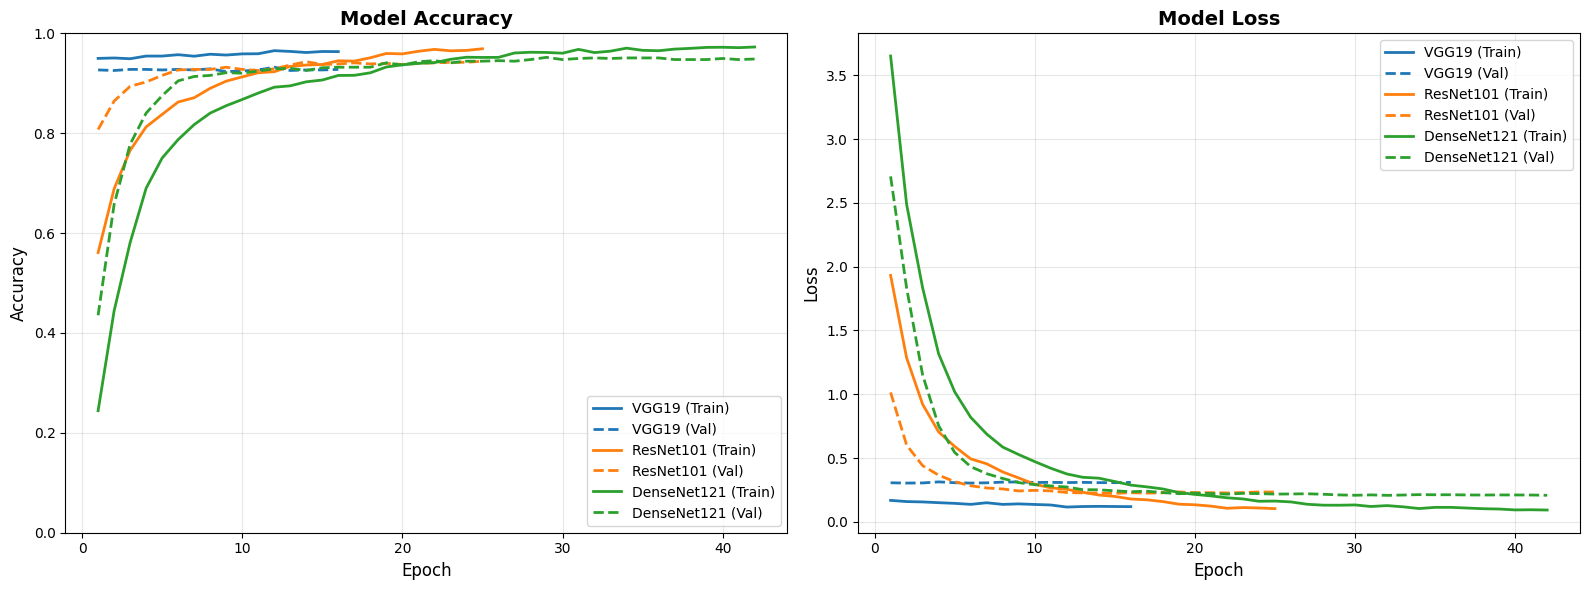

Training curves saved to: training_curves.png


In [ ]:
def plot_training_history(histories: Dict[str, keras.callbacks.History], metric: str = 'accuracy'):
    """Plot training curves for all models."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for idx, (model_name, history) in enumerate(histories.items()):
        epochs = range(1, len(history.history[metric]) + 1)
        
        axes[0].plot(epochs, history.history[metric], 
                     color=colors[idx], linestyle='-', linewidth=2,
                     label=f'{model_name} (Train)')
        axes[0].plot(epochs, history.history[f'val_{metric}'], 
                     color=colors[idx], linestyle='--', linewidth=2,
                     label=f'{model_name} (Val)')
    
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    for idx, (model_name, history) in enumerate(histories.items()):
        epochs = range(1, len(history.history['loss']) + 1)
        
        axes[1].plot(epochs, history.history['loss'], 
                     color=colors[idx], linestyle='-', linewidth=2,
                     label=f'{model_name} (Train)')
        axes[1].plot(epochs, history.history['val_loss'], 
                     color=colors[idx], linestyle='--', linewidth=2,
                     label=f'{model_name} (Val)')
    
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Training curves saved to: training_curves.png")

plot_training_history(training_histories)

## 14. Individual Model Training Curves

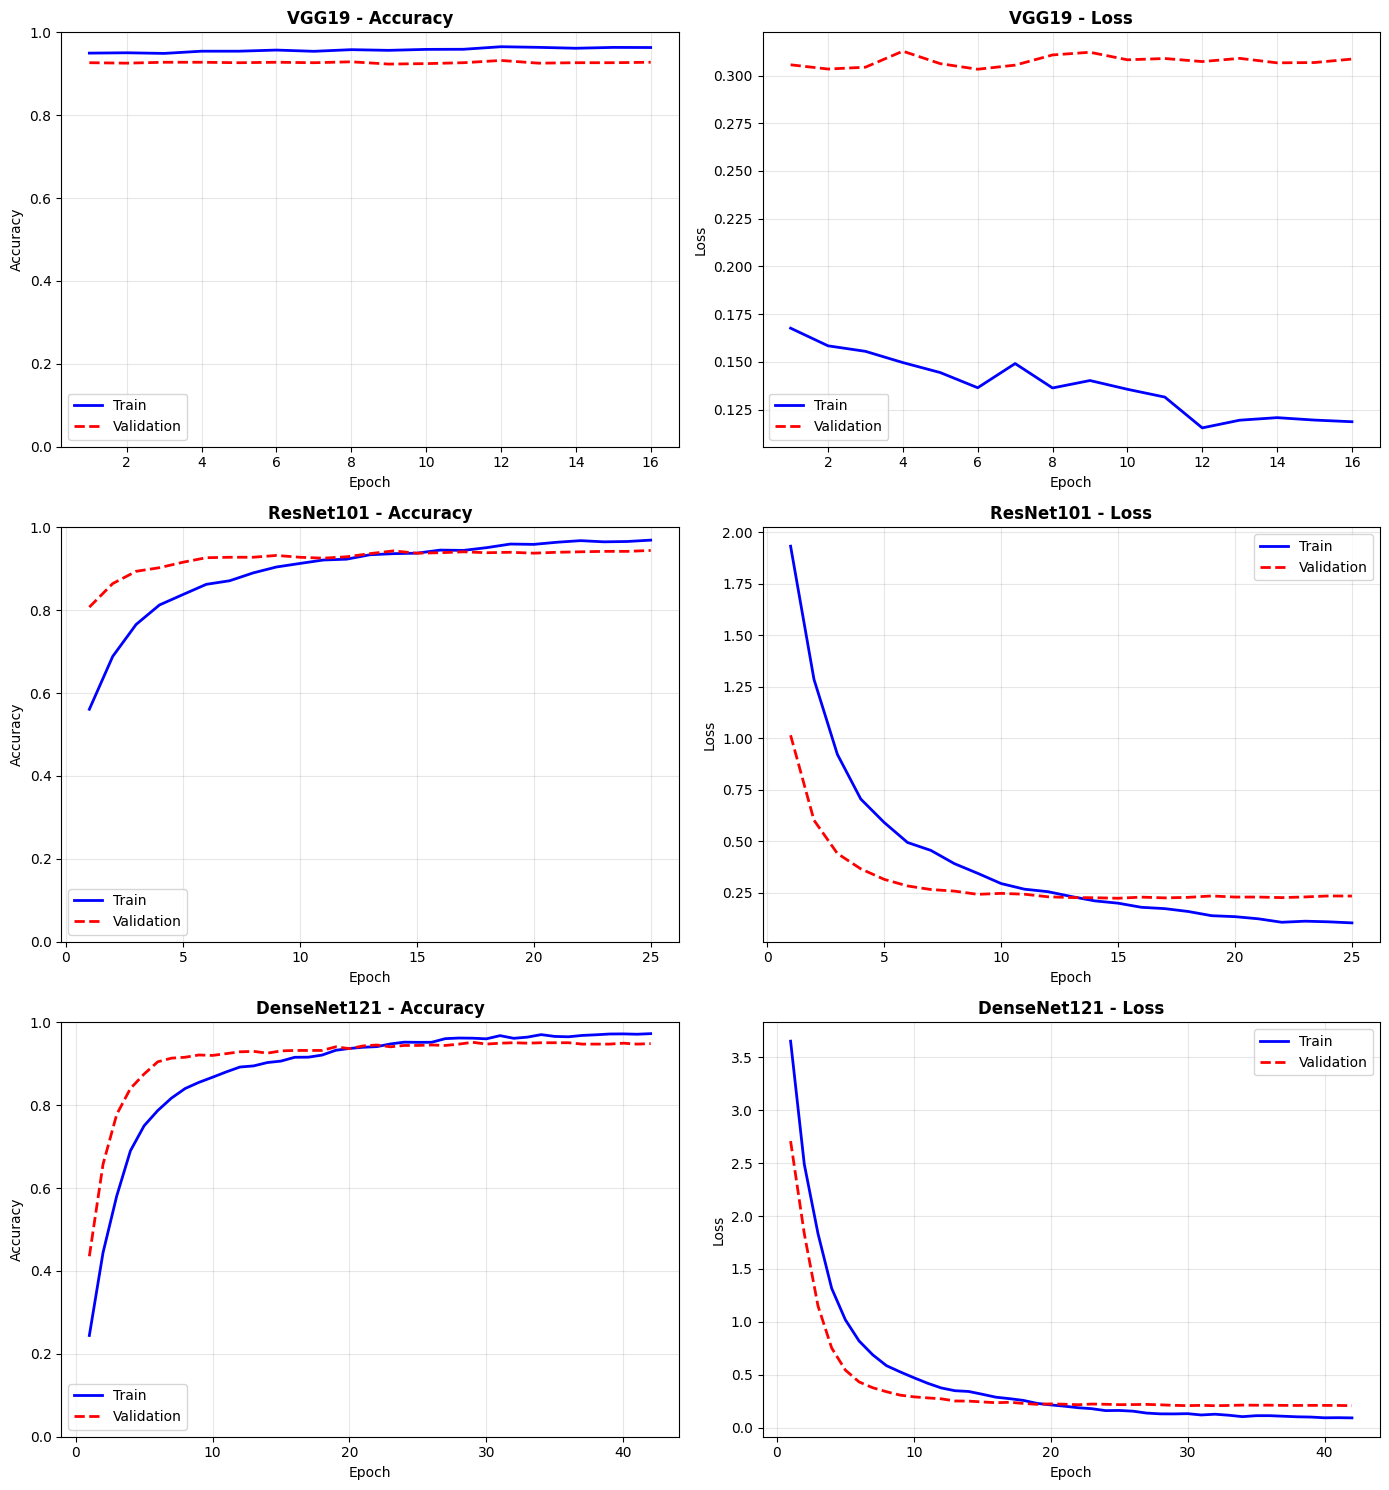

Individual curves saved to: individual_training_curves.png


In [ ]:
def plot_individual_model_curves(histories: Dict[str, keras.callbacks.History]):
    """Plot individual training curves for each model."""
    n_models = len(histories)
    fig, axes = plt.subplots(n_models, 2, figsize=(14, 5 * n_models))
    
    if n_models == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (model_name, history) in enumerate(histories.items()):
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        axes[idx, 0].plot(epochs, history.history['accuracy'], 'b-', linewidth=2, label='Train')
        axes[idx, 0].plot(epochs, history.history['val_accuracy'], 'r--', linewidth=2, label='Validation')
        axes[idx, 0].set_title(f'{model_name} - Accuracy', fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel('Epoch')
        axes[idx, 0].set_ylabel('Accuracy')
        axes[idx, 0].legend()
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].set_ylim([0, 1])
        
        axes[idx, 1].plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Train')
        axes[idx, 1].plot(epochs, history.history['val_loss'], 'r--', linewidth=2, label='Validation')
        axes[idx, 1].set_title(f'{model_name} - Loss', fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel('Epoch')
        axes[idx, 1].set_ylabel('Loss')
        axes[idx, 1].legend()
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('individual_training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Individual curves saved to: individual_training_curves.png")

plot_individual_model_curves(training_histories)

## 15. Model Comparison Bar Chart

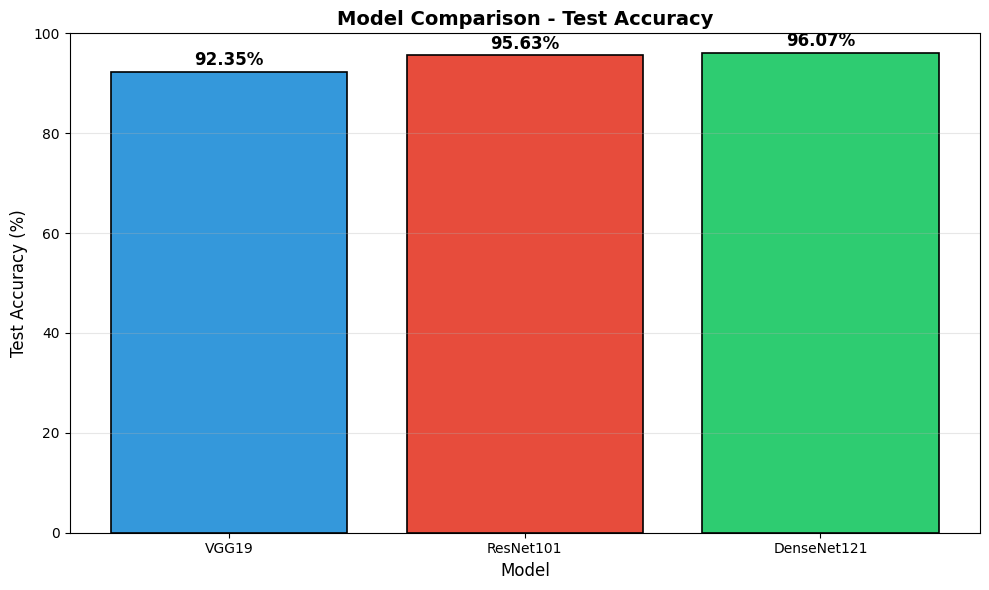

Model comparison saved to: model_comparison.png


In [ ]:
def plot_model_comparison(test_results: dict):
    """Bar chart comparing test accuracy across models."""
    models = list(test_results.keys())
    accuracies = [test_results[m]['accuracy'] * 100 for m in models]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)
    
    for bar, acc in zip(bars, accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.set_title('Model Comparison - Test Accuracy', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Model comparison saved to: model_comparison.png")

plot_model_comparison(test_results)

## 16. Save Final Models

In [ ]:
FINAL_MODELS_DIR = Path('final_models')
FINAL_MODELS_DIR.mkdir(exist_ok=True)

for model_name, model in trained_models.items():
    save_path = FINAL_MODELS_DIR / f"{model_name}_final.keras"
    model.save(save_path)
    print(f"Saved {model_name} to: {save_path}")

class_names_path = FINAL_MODELS_DIR / 'class_names.txt'
with open(class_names_path, 'w') as f:
    for name in CLASS_NAMES:
        f.write(f"{name}\n")
print(f"Saved class names to: {class_names_path}")

print("\n" + "="*80)
print("TRAINING PIPELINE COMPLETE")
print("="*80)
print(f"\nCheckpoints directory: {CHECKPOINT_DIR}")
print(f"Final models directory: {FINAL_MODELS_DIR}")
print(f"Visualization files: training_curves.png, individual_training_curves.png, model_comparison.png")

Saved VGG19 to: final_models/VGG19_final.keras
Saved ResNet101 to: final_models/ResNet101_final.keras
Saved DenseNet121 to: final_models/DenseNet121_final.keras
Saved class names to: final_models/class_names.txt

TRAINING PIPELINE COMPLETE

Checkpoints directory: checkpoints
Final models directory: final_models
Visualization files: training_curves.png, individual_training_curves.png, model_comparison.png


## 17. Individual Model Predictions

Use these cells to make predictions with each model separately. You can provide an image path or use a random test image.

In [ ]:
# Helper function for single image prediction
def predict_single_image(model, model_name: str, image_path: str, top_k: int = 5):
    """
    Make a prediction on a single image using a specific model.
    
    Args:
        model: The trained Keras model
        model_name: Name of the model (for preprocessing selection)
        image_path: Path to the image file
        top_k: Number of top predictions to show
    
    Returns:
        Dictionary with predictions
    """
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, CONFIG['img_size'])
    img = tf.cast(img, tf.float32)
    
    # Apply model-specific preprocessing
    preprocess_fn = PREPROCESS_FUNCTIONS[model_name]
    img = preprocess_fn(img)
    
    # Add batch dimension
    img = tf.expand_dims(img, 0)
    
    # Predict
    predictions = model.predict(img, verbose=0)[0]
    
    # Get top-k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    
    results = {
        'image_path': image_path,
        'model': model_name,
        'predictions': []
    }
    
    for idx in top_indices:
        results['predictions'].append({
            'class': CLASS_NAMES[idx],
            'confidence': float(predictions[idx])
        })
    
    return results

def display_prediction(results: dict, show_image: bool = True):
    """Display prediction results with optional image."""
    print(f"\n{'='*60}")
    print(f"Model: {results['model']}")
    print(f"Image: {results['image_path']}")
    print(f"{'='*60}")
    
    if show_image:
        img = plt.imread(results['image_path'])
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {results['predictions'][0]['class']}")
        plt.show()
    
    print(f"\nTop {len(results['predictions'])} Predictions:")
    print("-" * 40)
    for i, pred in enumerate(results['predictions'], 1):
        confidence = pred['confidence'] * 100
        bar = '█' * int(confidence / 5) + '░' * (20 - int(confidence / 5))
        print(f"{i}. {pred['class']:<25} {bar} {confidence:.2f}%")

print("Prediction helper functions loaded.")

Prediction helper functions loaded.


## 16.1 Predict with VGG19


Model: VGG19
Image: caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg


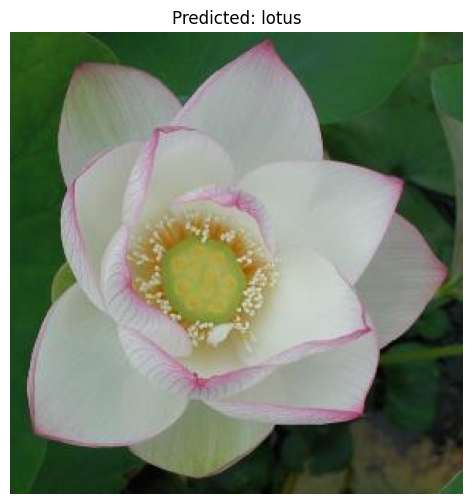


Top 5 Predictions:
----------------------------------------
1. lotus                     ███████████████████░ 99.07%
2. water_lilly               ░░░░░░░░░░░░░░░░░░░░ 0.45%
3. butterfly                 ░░░░░░░░░░░░░░░░░░░░ 0.30%
4. sunflower                 ░░░░░░░░░░░░░░░░░░░░ 0.08%
5. strawberry                ░░░░░░░░░░░░░░░░░░░░ 0.03%

True label: lotus


In [ ]:
# ============================================
# PREDICT WITH VGG19
# ============================================

# Option 1: Use a random test image
random_idx = np.random.randint(0, len(test_paths))
sample_image_path = test_paths[random_idx]
true_label = CLASS_NAMES[test_labels[random_idx]]

# Option 2: Specify your own image path (uncomment and modify)
# sample_image_path = "path/to/your/image.jpg"

# Load model (from memory or checkpoint)
if 'VGG19' in trained_models:
    vgg19_model = trained_models['VGG19']
else:
    vgg19_checkpoint = CHECKPOINT_DIR / "VGG19_best.keras"
    vgg19_model = keras.models.load_model(vgg19_checkpoint)
    print(f"Loaded VGG19 from: {vgg19_checkpoint}")

# Make prediction
vgg19_results = predict_single_image(vgg19_model, 'VGG19', sample_image_path, top_k=5)
display_prediction(vgg19_results)

print(f"\nTrue label: {true_label}")

## 16.2 Predict with ResNet101


Model: ResNet101
Image: caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg


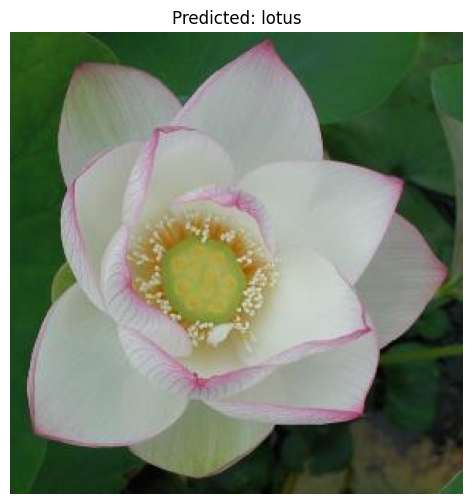


Top 5 Predictions:
----------------------------------------
1. lotus                     ███████████████████░ 99.33%
2. water_lilly               ░░░░░░░░░░░░░░░░░░░░ 0.61%
3. sunflower                 ░░░░░░░░░░░░░░░░░░░░ 0.02%
4. BACKGROUND_Google         ░░░░░░░░░░░░░░░░░░░░ 0.01%
5. chandelier                ░░░░░░░░░░░░░░░░░░░░ 0.01%

True label: cougar_face


In [ ]:
# ============================================
# PREDICT WITH ResNet101
# ============================================

# Option 1: Use a random test image
# random_idx = np.random.randint(0, len(test_paths))
# sample_image_path = test_paths[random_idx]
# true_label = CLASS_NAMES[test_labels[random_idx]]

# Option 2: Specify your own image path (uncomment and modify)
sample_image_path = "caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg"

# Load model (from memory or checkpoint)
if 'ResNet101' in trained_models:
    resnet_model = trained_models['ResNet101']
else:
    resnet_checkpoint = CHECKPOINT_DIR / "ResNet101_best.keras"
    resnet_model = keras.models.load_model(resnet_checkpoint)
    print(f"Loaded ResNet101 from: {resnet_checkpoint}")

# Make prediction
resnet_results = predict_single_image(resnet_model, 'ResNet101', sample_image_path, top_k=5)
display_prediction(resnet_results)

print(f"\nTrue label: {true_label}")

## 16.3 Predict with DenseNet121


Model: DenseNet121
Image: caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg


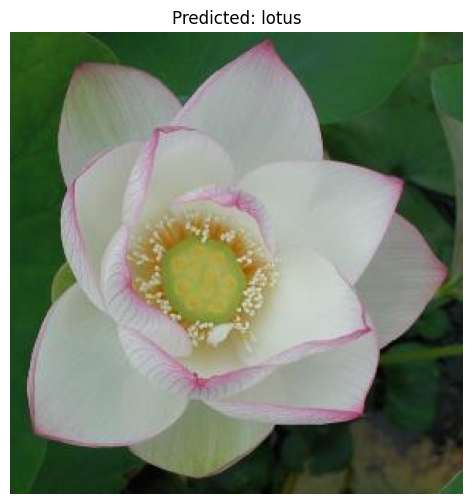


Top 5 Predictions:
----------------------------------------
1. lotus                     ███████████████████░ 95.64%
2. water_lilly               ░░░░░░░░░░░░░░░░░░░░ 4.35%
3. sunflower                 ░░░░░░░░░░░░░░░░░░░░ 0.00%
4. butterfly                 ░░░░░░░░░░░░░░░░░░░░ 0.00%
5. strawberry                ░░░░░░░░░░░░░░░░░░░░ 0.00%

True label: cougar_face


In [ ]:
# ============================================
# PREDICT WITH DenseNet121
# ============================================

# Option 1: Use a random test image
# random_idx = np.random.randint(0, len(test_paths))
# sample_image_path = test_paths[random_idx]
# true_label = CLASS_NAMES[test_labels[random_idx]]

# Option 2: Specify your own image path (uncomment and modify)
sample_image_path = "caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg"

# Load model (from memory or checkpoint)
if 'DenseNet121' in trained_models:
    densenet_model = trained_models['DenseNet121']
else:
    densenet_checkpoint = CHECKPOINT_DIR / "DenseNet121_best.keras"
    densenet_model = keras.models.load_model(densenet_checkpoint)
    print(f"Loaded DenseNet121 from: {densenet_checkpoint}")

# Make prediction
densenet_results = predict_single_image(densenet_model, 'DenseNet121', sample_image_path, top_k=5)
display_prediction(densenet_results)

print(f"\nTrue label: {true_label}")

## 16.4 Compare All Models on Same Image

In [ ]:
# ============================================
# COMPARE ALL MODELS ON THE SAME IMAGE
# ============================================

# Pick a random test image
random_idx = np.random.randint(0, len(test_paths))
comparison_image_path = test_paths[random_idx]
true_label = CLASS_NAMES[test_labels[random_idx]]

# comparison_image_path = "caltech101_data/caltech-101/101_ObjectCategories/lotus/image_0006.jpg"

print(f"Comparing all models on: {comparison_image_path}")
print(f"True label: {true_label}")

# Show the image
img = plt.imread(comparison_image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"True: {true_label}")
plt.show()

# Predict with each model
all_predictions = {}
for model_name in MODELS_TO_TRAIN:
    if model_name in trained_models:
        model = trained_models[model_name]
    else:
        checkpoint = CHECKPOINT_DIR / f"{model_name}_best.keras"
        model = keras.models.load_model(checkpoint)
    
    results = predict_single_image(model, model_name, comparison_image_path, top_k=3)
    all_predictions[model_name] = results['predictions']

# Display comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(f"\n{'Model':<15} {'Top-1 Prediction':<25} {'Confidence':<12} {'Correct?'}")
print("-" * 70)

for model_name, preds in all_predictions.items():
    top_pred = preds[0]['class']
    confidence = preds[0]['confidence'] * 100
    is_correct = "✓" if top_pred == true_label else "✗"
    print(f"{model_name:<15} {top_pred:<25} {confidence:>8.2f}%    {is_correct}")

NameError: name 'test_paths' is not defined